<h1 style = "text-align:center;">Classification of Humans and Horse</h1>


In [1]:
# Importing Libraries

import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D , BatchNormalization 
from tensorflow.keras.optimizers import RMSprop
import os
import math

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [2]:
# GPU Configurations

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [3]:
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_CHANNELS = 3

train_dir = "./horse-or-human/"
test_dir = "./test-horse-or-human/"

epochs = 30
BATCH_SIZE = 32

In [4]:
# Data Augmentation and setting training generator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode="rgb",
    class_mode="binary",
    batch_size=8,
    shuffle=True
)

Found 1027 images belonging to 2 classes.


In [5]:
# Data Augmentation and setting Testing generator

test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode="rgb",
    class_mode="binary",
    batch_size=8,
    shuffle=True
)

Found 256 images belonging to 2 classes.


In [6]:
# Model

model = Sequential()

model.add(Conv2D(filters = 32 , kernel_size = 3 , activation = "relu" , input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, IMAGE_CHANNELS) , padding = "same"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32 , kernel_size = 3 , padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128 , kernel_size = 3 , padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters = 128 , kernel_size = 3 , padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(1 , activation = "sigmoid"))

model.summary()

model.compile(optimizer = RMSprop(lr=0.01) , loss = "binary_crossentropy" , metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 32)      0

In [7]:
# Callbacks

class ConvolutionCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>=0.93 and logs.get('val_accuracy') >=0.91):
                print("Reached greater than 95.0% accuracy so cancelling training!")
                self.model.stop_training = True
                
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint("./Models/HumansAndHorses_model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

convolutionCallback = ConvolutionCallback()
callbacks = [PlotLossesKerasTF(), checkpoint,reduce_lr, convolutionCallback]

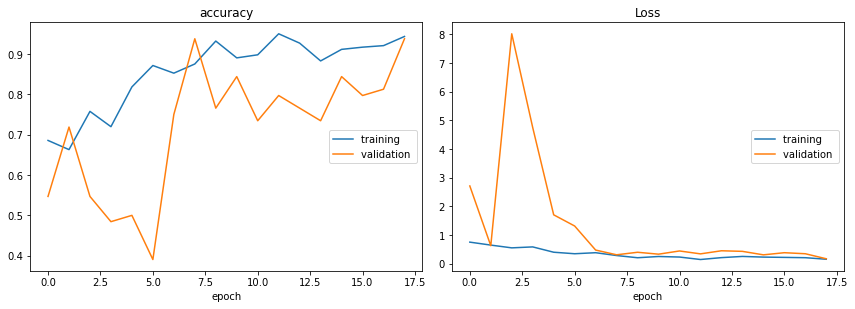

accuracy
	training         	 (min:    0.663, max:    0.950, cur:    0.943)
	validation       	 (min:    0.391, max:    0.938, cur:    0.938)
Loss
	training         	 (min:    0.146, max:    0.752, cur:    0.156)
	validation       	 (min:    0.172, max:    8.014, cur:    0.172)

Epoch 00018: saving model to ./Models/HumansAndHorses_model_weights.h5
Reached greater than 95.0% accuracy so cancelling training!
33/33 [==============================] - 7s 211ms/step - loss: 0.1556 - accuracy: 0.9432 - val_loss: 0.1715 - val_accuracy: 0.9375 - lr: 0.0010


In [8]:
# Running the model

history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    validation_steps = int(math.ceil(1. * 256 / BATCH_SIZE)),
    steps_per_epoch = int(math.ceil(1. * 1027 / BATCH_SIZE)),
    callbacks=callbacks
)

In [26]:
model.evaluate(test_generator)

32/32 [==============================] - 1s 32ms/step - loss: 0.1928 - accuracy: 0.9453


[0.19280564785003662, 0.9453125]

Enter Image Name (from 1-11) : 5

./PredictingImages/5.jpg


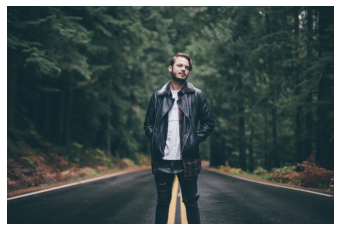

[[0.]]
[0.]
Human


In [27]:
import numpy as np
from keras.preprocessing import image
import matplotlib.image as mpimg

# predicting images
path = input("Enter Image Name (from 1-11) : ")
path = "./PredictingImages/" + path + ".jpg"

img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print()
print(path)
plt.axis("Off")
img = mpimg.imread(path)
plt.imshow(img)
plt.show()

print(classes)
print(classes[0])

if classes[0]>0.5:
    print("Horse")
else:
    print("Human")